# Lab Session 3: Morphology

In this work the following tasks are performed:
- Introduction of the main performance measurements: ALL, ALLNORM and WEIGHTED MEAN
- Comparison of the performance of the lemmatizer and the morphological analyzer
- N-Grams analysis for cleaning the corpus
- Cleaning the corpus
- Reached a significant improvement in out task **(from 0.57 to 0.63 in ALL)**

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr
import spacy
nlp = spacy.load("en_core_web_sm")

from nltk.corpus import wordnet as wn
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import download
import nltk
from nltk.metrics import jaccard_distance

import re
from sklearn.linear_model import RidgeCV

download('averaged_perceptron_tagger')
download('wordnet')
download('omw-1.4')
download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [55]:
def jaccard_sim(x, y):
    '''
    Returns the Jaccard similarity between two sets
    '''
    return 1 - jaccard_distance(x, y)

class STSAnalyzer:

    def __init__(self, preprocess_fun, name=None, similarity=jaccard_sim, semantic_fun=None):
        self.preprocess_fun = preprocess_fun
        self.name = name
        self.similarity = similarity
        self.semantic_fun = semantic_fun

    def get_similarity(self, x, y):
        '''
        Get the similarity between two strings
        '''
        if self.semantic_fun is not None:
            x_preprep, y_preprep = self.semantic_fun(x, y)
        else:
            x_preprep, y_preprep = x, y
            
        # Clean the sentences and return a set of words
        x_prep = self.preprocess_fun(x_preprep, out_set=True)
        y_prep = self.preprocess_fun(y_preprep, out_set=True)

        # Return the similarity between the two sets of words
        return self.similarity(x_prep, y_prep)
        
    def corr_with_gold(self, filename):
        '''
        Returns the correlation between the gold standard and the similarity
        Input: filename - string with the name of the file
        Output: Pearson correlation object
        '''

        # In some of the files, tabulations appear as \t instead of a tab
        # To solve this problem, it's been included \\t (escaped "\") as a possible separator
        dt = pd.read_csv('../test-gold/STS.input.' + filename, sep='\t|\\t',
                        header=None, on_bad_lines='skip', engine='python')
        dt['gs'] = pd.read_csv('../test-gold/STS.gs.'+ filename, sep='\t|\\t',header=None, 
                            on_bad_lines='skip', engine='python')
        
        # dt.drop_duplicates(subset = [0, 1], keep=False, inplace = True)

        # Bad lines are inserted as null values sometimes 
        # They are counted, informed and removed
        nulls = dt[dt.isnull().any(axis=1)]
        if len(nulls) > 0:
            print(filename, '\n', nulls)
            dt = dt.dropna()

        # Get the similarity between the two sentences
        arr_sim = dt.apply(lambda x: self.get_similarity(*x[:2]) , axis=1).values
        
        return pearsonr(arr_sim, dt['gs'].values)

    def ind_report(self, file, n_show=10):

        print("=====================================================")
        print(file)
        print("=====================================================")
        print("\n")
        df_ind_report = pd.read_csv(f'../test-gold/STS.input.{file}',sep='\t|\\t',header=None, engine='python')
        # df_ind_report.drop_duplicates(subset = [0, 1], keep=False, inplace = True)
        df_ind_report['gs'] = pd.read_csv(f'../test-gold/STS.gs.{file}',sep='\t|\\t',header=None, engine='python')
        df_ind_report['sim'] = df_ind_report.apply(lambda x: self.get_similarity(*x[:2]) , axis=1)
        df_ind_report['sim'] *= 5.
        df_ind_report['dif'] = df_ind_report['sim'] - df_ind_report['gs']

        if n_show is not None:
            difs_tail = df_ind_report.sort_values(by='dif', ascending=False).tail(n_show)
        else:
            difs_tail = df_ind_report.sort_values(by='dif', ascending=False)
            
        for idx, row in difs_tail.iterrows():
            x, y = row[0], row[1]
            prep_x, prep_y = self.preprocess_fun(x, out_set=True), self.preprocess_fun(y, out_set=True)
            print(f"RAW TEXT (DIFFERENCE {row['dif']:.2f})")
            print(x, '\n', y)
            print("\nPREPROCESSED TEXT")
            print(prep_x, '\n', prep_y)
            print("INTERSECTION", prep_x.intersection(prep_y))
            print("DIFFERENCE", prep_x.difference(prep_y).union(prep_y.difference(prep_x)))
            print('\n\n')

            if self.semantic_fun is not None:
                print("SEMANTICAL MODIFICATION\n")
                x, y = self.semantic_fun(row[0], row[1])
                prep_x, prep_y = self.preprocess_fun(x, out_set=True), self.preprocess_fun(y, out_set=True)
                print(f"RAW TEXT (DIFFERENCE {row['dif']:.2f})")
                print(x, '\n', y)
                print("\nPREPROCESSED TEXT")
                print(prep_x, '\n', prep_y)
                print("INTERSECTION", prep_x.intersection(prep_y))
                print("DIFFERENCE", prep_x.difference(prep_y).union(prep_y.difference(prep_x)))
                print('\n\n')

        fig, ax = plt.subplots(1, 2, figsize=(10,2.5))
        plt.suptitle(file)
        df_ind_report.dif.plot.hist(bins=20, title="Residuals", ax=ax[0])
        df_ind_report.dif.plot.box(title="Residuals", ax=ax[1]);
        
        self.df_ind_report = df_ind_report

    def corr_table(self, ls_files):
        
        df_scores = pd.DataFrame(columns=['file','pearson','p_value', 'conf_low', 'conf_high'])

        ls_corr = []
        ls_p_value = []
        ls_conf_low, ls_conf_high = [], []

        for file in ls_files:
            print(f"Processing {file}")
            pearson_stats = self.corr_with_gold(file)
            ls_corr.append(pearson_stats.statistic)
            ls_p_value.append(pearson_stats.pvalue)
            ls_conf_low.append(pearson_stats.confidence_interval(.95).low)
            ls_conf_high.append(pearson_stats.confidence_interval(.95).high)

        df_scores['file'] = ls_files
        df_scores['pearson'] = ls_corr
        df_scores['p_value'] = ls_p_value
        df_scores['conf_low'] = ls_conf_low
        df_scores['conf_high'] = ls_conf_high
        
        if self.name is not None:
            df_scores['name'] = self.name

        self.df_scores = df_scores
        return df_scores
    
    def col_report(self, ls_files, n_show=10):

        # pool = mp.Pool(processes=len(ls_files))  # Use all available CPU cores

        # # Use the pool to parallelize the execution of self.ind_report for each file
        # results = pool.map(self.ind_report, ls_files)

        # # Close the pool and wait for all processes to finish
        # pool.close()
        # pool.join()
        # print(results)
        # # Concatenate the results into a single DataFrame
        # df_col_analysis = pd.DataFrame()
        # for file, df_ind in zip(ls_files, results):
        #     df_ind['file'] = file
        #     df_col_analysis = pd.concat([df_col_analysis, df_ind], axis=0)

        df_col_analysis = pd.DataFrame()
        for file in ls_files:
            self.ind_report(file, n_show=n_show)
            df_ind = self.df_ind_report
            df_ind['file'] = file
            df_col_analysis = pd.concat([df_col_analysis, df_ind], axis=0)
        
        # Pearson correlation for the concatenation of all five datasets
        self.total_corr = pearsonr(df_col_analysis['sim'].values, df_col_analysis['gs'].values)

        # Autoscaled correlation (ALLNORM)
        reg = RidgeCV(alphas=np.logspace(-6, 6, 13), cv=3)
        arr_preds = np.concatenate(df_col_analysis.groupby('file').\
                                    apply(lambda x: reg.fit(x.sim.values.reshape(-1, 1), x.gs.values).predict(x.sim.values.reshape(-1, 1))).values)
        self.allnorm = pearsonr(arr_preds, df_col_analysis['gs'].values)
        
        # Weighted mean correlation (WMEAN)
        self.w_mean = df_col_analysis.groupby('file').\
                        apply(lambda x: pearsonr(x.sim.values, x.gs.values).statistic * x.shape[0] / df_col_analysis.shape[0]).sum()
        
        # Weighted mean of the Pearson correlations on individual datasets
        df_global_scores = pd.DataFrame(columns=['all', 'allnorm', 'wmean'])
        df_global_scores.loc[0] = [self.total_corr[0], self.allnorm[0], self.w_mean]
        if self.name is not None:
            df_global_scores['name'] = self.name
        self.df_global_scores = df_global_scores

        self.df_col_analysis = df_col_analysis

        return df_global_scores
    
    def plot_col_analysis(self, ls_sts=[]):
        df_scores_comp = self.df_scores.copy()
        df_global_scores_comp = self.df_global_scores.copy()

        if ls_sts != []:
            for sts in ls_sts:
                df_scores_comp = pd.concat([df_scores_comp, sts.df_scores], 
                                             axis=0, ignore_index=True)
                df_global_scores_comp = pd.concat([df_global_scores_comp, sts.df_global_scores],
                                                     axis=0, ignore_index=True)
                
        plt.figure(figsize=(10,5))
        sns.barplot(x='file', y='pearson', hue='name', data=df_scores_comp)
        plt.title('Pearson correlation between similarity and gold standard for different preprocessings')
        plt.xticks(rotation=45)

        df_global_comp_plot = df_global_scores_comp.melt(id_vars='name', value_vars=['all', 'allnorm', 'wmean'])
        plt.figure(figsize=(10,5))
        sns.lineplot(x="variable", y="value", hue="name", data=df_global_comp_plot, marker='o')
        plt.ylim(0.5, 1.);
        
                        

# Spacy Baseline

MSRpar.txt


RAW TEXT (DIFFERENCE -2.94)
General Jeffrey said he would donate his military pension to charity for the period he was in office at Yarralumla. 
 Maj-Gen Jeffery said he would give his military pension to charity while he served at Yarralumla.

PREPROCESSED TEXT
{'general', 'said', 'jeffrey', 'donate', 'charity', 'military', 'period', 'pension', 'yarralumla', 'office'} 
 {'gen', 'served', 'pension', 'said', 'charity', 'military', 'maj', 'yarralumla', 'jeffery'}
INTERSECTION {'said', 'charity', 'military', 'pension', 'yarralumla'}
DIFFERENCE {'gen', 'general', 'served', 'jeffrey', 'donate', 'period', 'maj', 'jeffery', 'office'}



RAW TEXT (DIFFERENCE -3.06)
But software license revenues, a measure financial analysts watch closely, decreased 21 percent to $107.6 million. 
 License sales, a key measure of demand, fell 21 percent to $107.6 million.

PREPROCESSED TEXT
{'percent', 'measure', 'software', 'closely', 'decreased', '107.6', 'financial', 'analysts', 'license', '21', 

,file,pearson,p_value,conf_low,conf_high,name
0,MSRpar.txt,0.553714,1.771364e-61,0.502026,0.601461,baseline
1,MSRvid.txt,0.688512,1.819221e-106,0.648908,0.724395,baseline
2,SMTeuroparl.txt,0.497331,4.734960e-30,0.425157,0.563221,baseline
3,surprise.OnWN.txt,0.621482,2.409448e-81,0.575498,0.663549,baseline
4,surprise.SMTnews.txt,0.417772,2.761735e-18,0.333266,0.495619,baseline


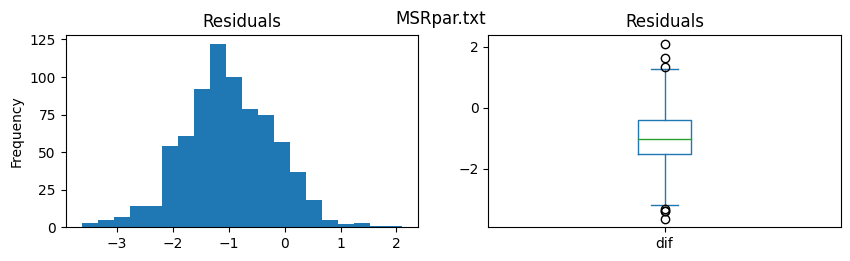

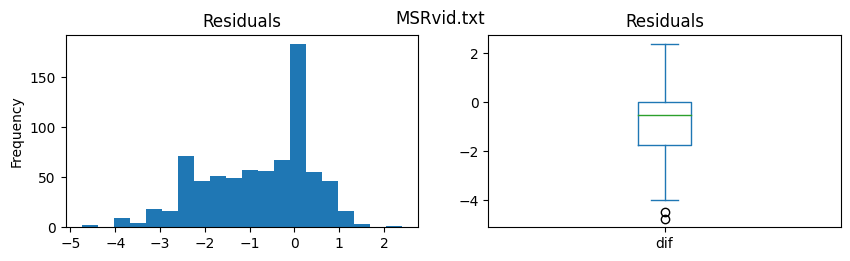

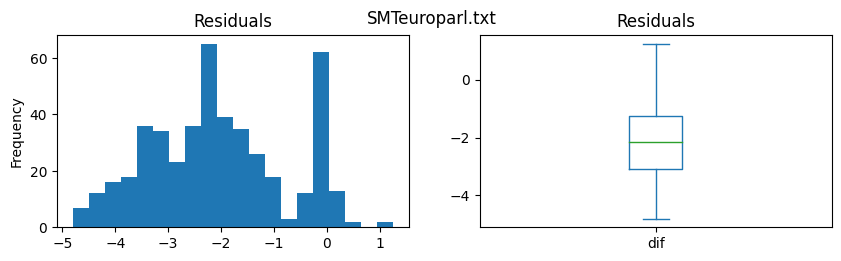

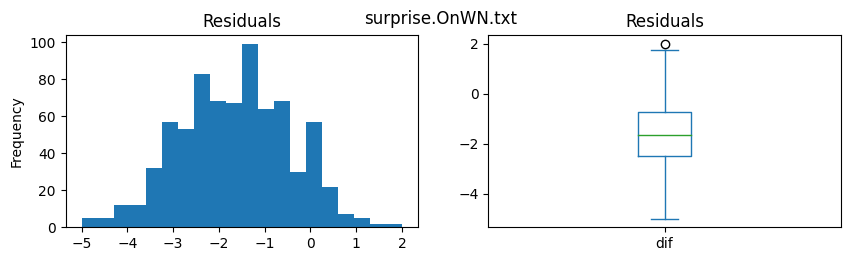

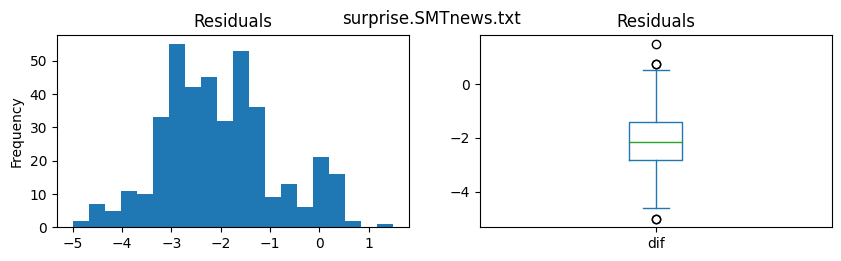

In [57]:
def spacy_preprocess_reviews(text, sw_lang='english', out_set=False, clean_func=None):
    '''
    Function to preprocess the text - remove punctuations, convert to lowercase, remove stopwords
    Input: text - string
    Output: ls_processed_text - list of words
    '''
    if clean_func is not None:
        text = clean_func(text)
    # formatted_text = clean_text(text)
    doc = nlp(text)
    ls_processed_text = [w.text.lower() for w in doc if not w.is_stop and not w.is_punct]
    if out_set:
        # For distance metrics, usually, it's needed a set of words
        return set(ls_processed_text)
    else:
        return ls_processed_text
    
ls_files = ["MSRpar.txt", "MSRvid.txt", "SMTeuroparl.txt", "surprise.OnWN.txt", "surprise.SMTnews.txt"]
baseline = STSAnalyzer(spacy_preprocess_reviews, name='baseline')
baseline.col_report(ls_files)
baseline.corr_table(ls_files)

In [58]:
baseline.df_global_scores

,all,allnorm,wmean,name
0,0.571166,0.7784,0.576817,baseline


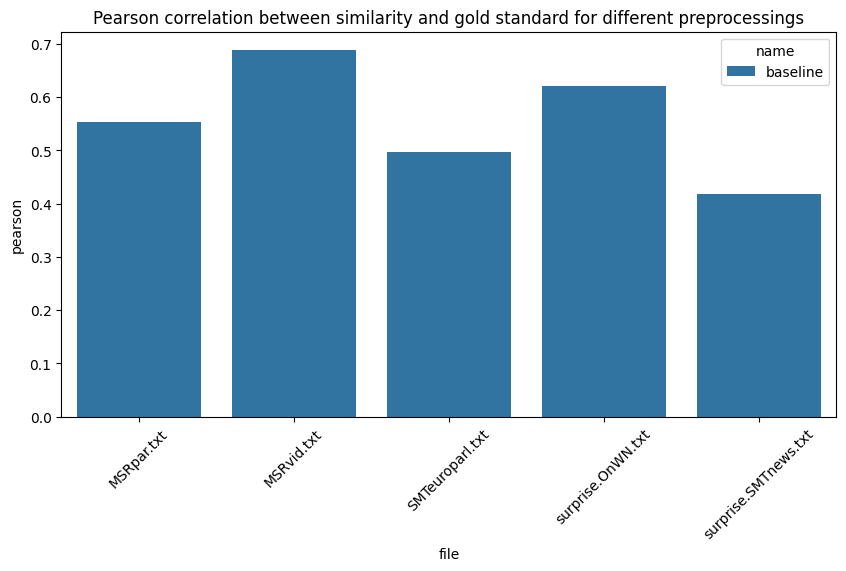

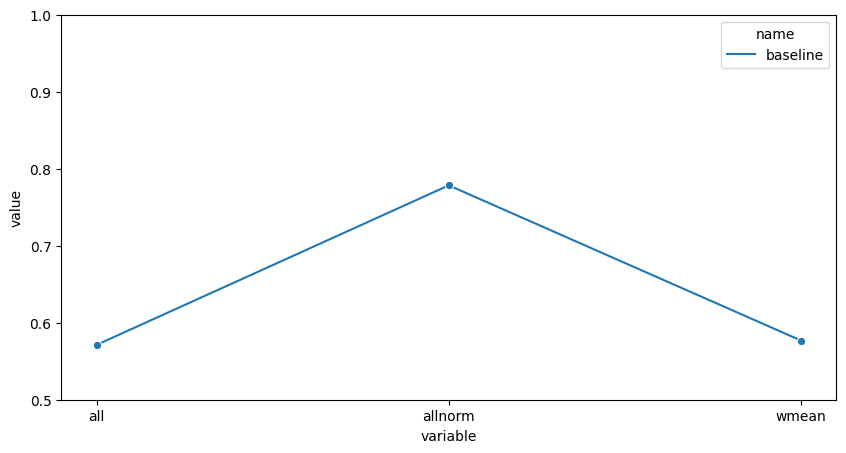

In [59]:
baseline.plot_col_analysis()

# Lemmatization and POS tagging

As seen in the baseline, using the whole word can result in the mismatch of the word form. In this section, we will use the lemmatized form of the word instead of the word itself. We will also use the POS tag of the word to further improve the performance.

Example from the baseline:

DIFFERENCE {'claims', 'date', 'var', 'xserve', 'xserves', 'single', 'retailer', 'claimed'}

"claims" and "claimed" correspond to the same concept but they haven't been identified as it because of the mismatch of the verb tense. Using the lemmatized form of the word, we can solve this problem.

Example not working: {'use', 'usage'}

MSRpar.txt


RAW TEXT (DIFFERENCE -2.93)
But butterflies exposed to an earlier light cycle, from 1am to 1pm, orientated themselves towards the south-east. 
 But butterflies housed under an earlier light cycle, 1 a.m. to 1 p.m., flew toward the southeast.

PREPROCESSED TEXT
{'east', 'cycle', 'early', 'expose', 'south', 'orientate', '1', 'light', 'butterfly', 'pm'} 
 {'cycle', 'fly', 'early', 'southeast', 'p.m.', '1', 'light', 'house', 'butterfly', 'a.m.'}
INTERSECTION {'cycle', 'early', '1', 'light', 'butterfly'}
DIFFERENCE {'east', 'fly', 'expose', 'south', 'a.m.', 'orientate', 'p.m.', 'house', 'southeast', 'pm'}



RAW TEXT (DIFFERENCE -2.94)
General Jeffrey said he would donate his military pension to charity for the period he was in office at Yarralumla. 
 Maj-Gen Jeffery said he would give his military pension to charity while he served at Yarralumla.

PREPROCESSED TEXT
{'general', 'jeffrey', 'donate', 'say', 'charity', 'military', 'period', 'pension', 'yarralumla', 'office'} 
 {'g

,file,pearson,p_value,conf_low,conf_high,name
0,MSRpar.txt,0.562467,8.643426e-64,0.511474,0.609513,lemmatization
1,MSRvid.txt,0.771316,6.223491e-149,0.740623,0.798797,lemmatization
2,SMTeuroparl.txt,0.523927,1.013398e-33,0.454179,0.587291,lemmatization
3,surprise.OnWN.txt,0.624870,1.813327e-82,0.579190,0.666637,lemmatization
4,surprise.SMTnews.txt,0.401410,7.023623e-17,0.315676,0.480644,lemmatization


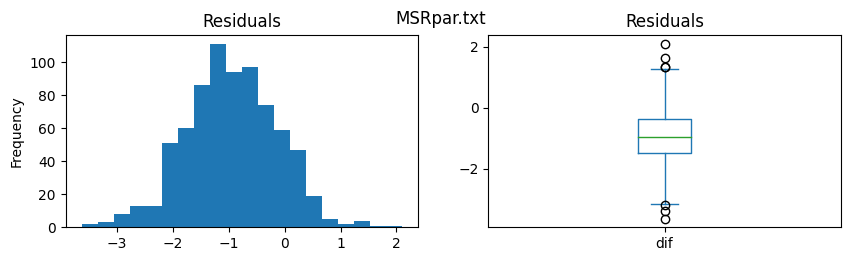

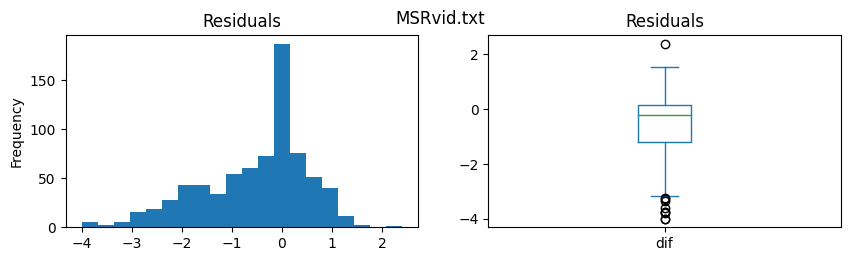

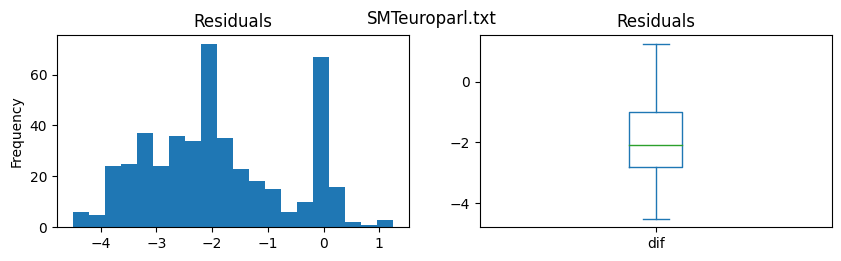

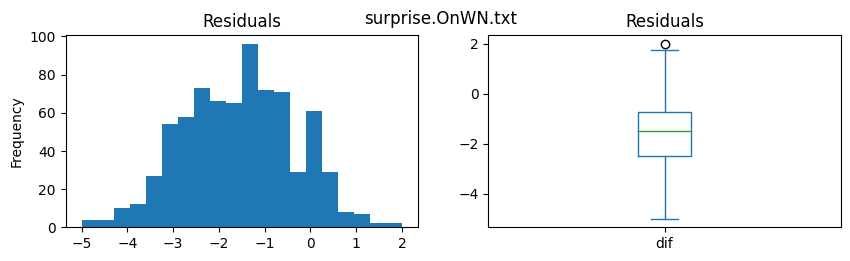

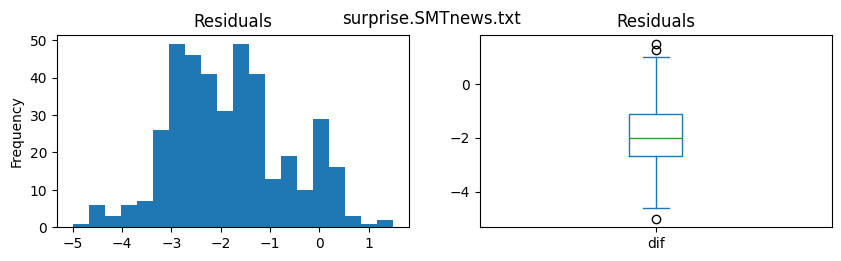

In [60]:
def spacy_preprocess_lemma(text, sw_lang='english', out_set=False, clean_func=None):
    '''
    Function to preprocess the text - remove punctuations, convert to lowercase, remove stopwords
    Input: text - string
    Output: ls_processed_text - list of words
    '''
    if clean_func is not None:
        text = clean_func(text)

    doc = nlp(text)
    ls_processed_text = [w.lemma_.lower() for w in doc if not w.is_stop and not w.is_punct]

    if out_set:
        # For distance metrics, usually, it's needed a set of words
        return set(ls_processed_text)
    else:
        return ls_processed_text
    
lemmatized = STSAnalyzer(spacy_preprocess_lemma, name='lemmatization')
lemmatized.col_report(ls_files)
lemmatized.corr_table(ls_files)

In [61]:
print(f"Global Metric: {lemmatized.total_corr.statistic:.6f}")
lemmatized.df_global_scores

Global Metric: 0.600490


,all,allnorm,wmean,name
0,0.60049,0.806036,0.601556,lemmatization


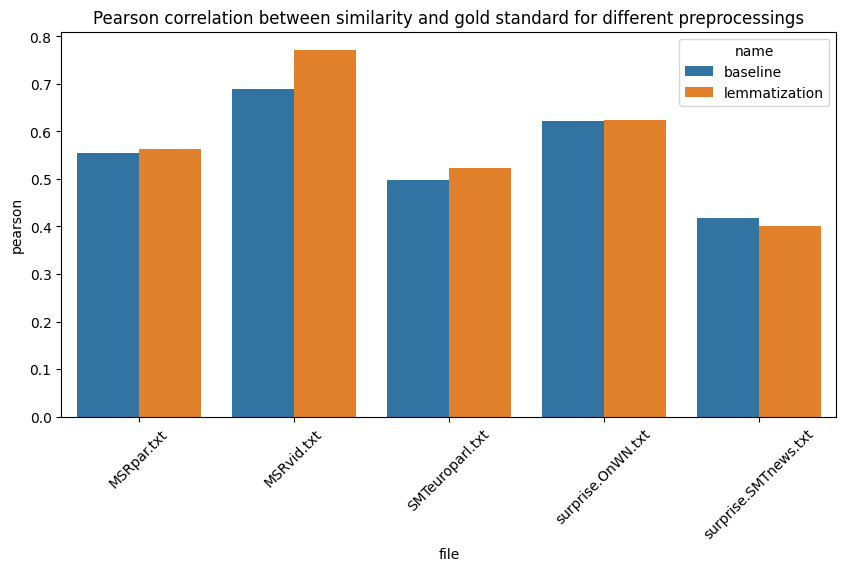

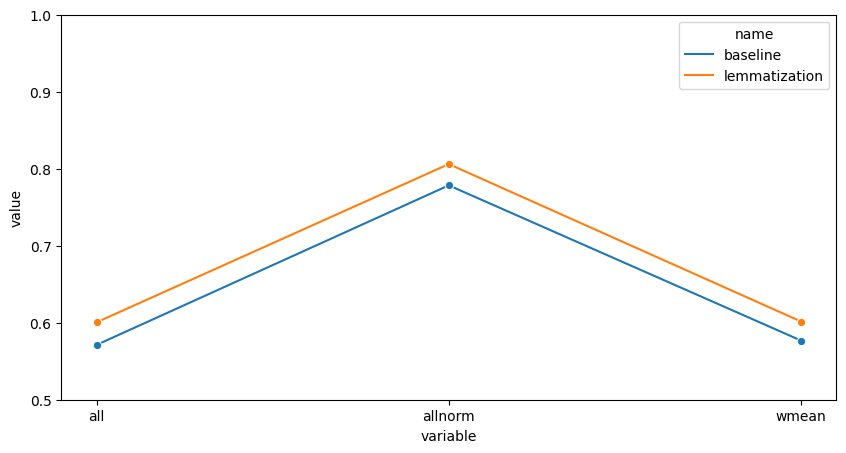

In [62]:
baseline.plot_col_analysis([lemmatized])

# Stemming

There are still some differencies between the words that have the same meaning

DIFFERENCE {'need', 'necessary'}
DIFFERENCE {'inflate', 'inflated', 'physically'}

or some like "potato" and "potatoe" that are just misspelled. We can use other word standardization techniques to solve this problem.

A good way of partially solving this can be chopping the words' termination using specific stemming rules. For example, we can use the Porter Stemmer algorithm to chop the words' termination.

## Porter Stemmer

MSRpar.txt


RAW TEXT (DIFFERENCE -2.93)
It's the first such drill since the September 11 terrorist attacks on New York and Washington. 
 It is the nation's first large-scale counterterrorism exercise since the Sept. 11 terrorist attacks.

PREPROCESSED TEXT
{'11', 'septemb', 'drill', 'york', 'terrorist', 'new', 'washington', 'attack'} 
 {'11', 'nation', 'larg', 'exercis', 'terrorist', 'sept.', 'scale', 'counterterror', 'attack'}
INTERSECTION {'11', 'attack', 'terrorist'}
DIFFERENCE {'septemb', 'nation', 'larg', 'drill', 'exercis', 'york', 'sept.', 'new', 'scale', 'washington', 'counterterror'}



RAW TEXT (DIFFERENCE -2.93)
But butterflies exposed to an earlier light cycle, from 1am to 1pm, orientated themselves towards the south-east. 
 But butterflies housed under an earlier light cycle, 1 a.m. to 1 p.m., flew toward the southeast.

PREPROCESSED TEXT
{'east', 'expos', 'cycl', 'south', 'orient', 'butterfli', '1', 'light', 'earli', 'pm'} 
 {'hous', 'southeast', 'cycl', 'fli', 'butterfl

,file,pearson,p_value,conf_low,conf_high,name
0,MSRpar.txt,0.574941,3.318976e-67,0.524959,0.620971,Lemma+Porter
1,MSRvid.txt,0.786032,2.117405e-158,0.757043,0.811933,Lemma+Porter
2,SMTeuroparl.txt,0.507617,1.969299e-31,0.436364,0.572543,Lemma+Porter
3,surprise.OnWN.txt,0.651277,1.005897e-91,0.608038,0.690664,Lemma+Porter
4,surprise.SMTnews.txt,0.409572,1.429425e-17,0.324443,0.488120,Lemma+Porter


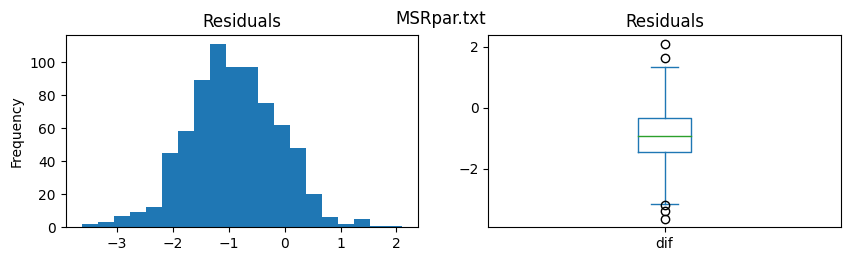

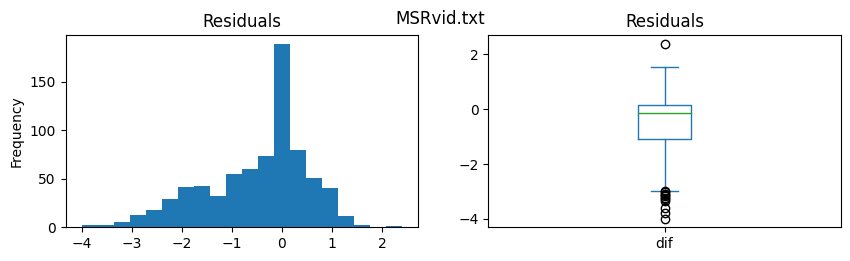

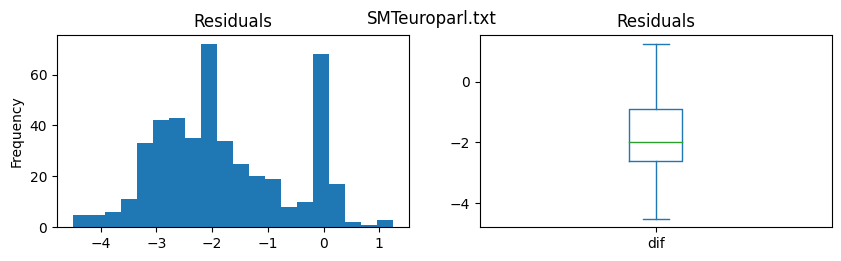

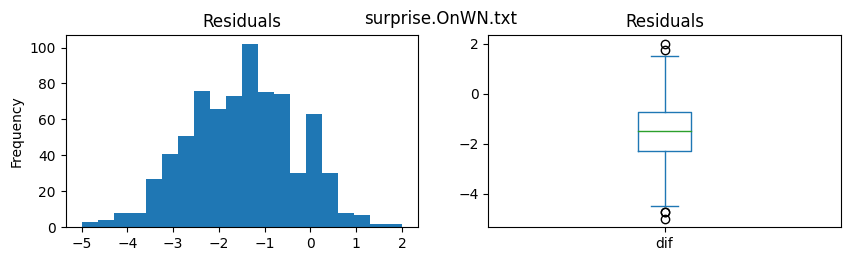

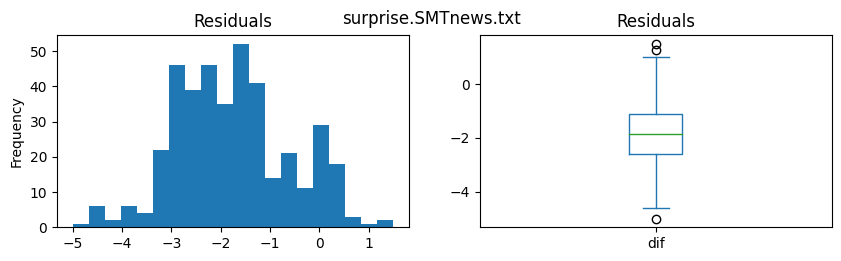

In [63]:
def spacy_preprocess_lemma_porter(text, sw_lang='english', out_set=False, clean_func=None):
    '''
    Function to preprocess the text - remove punctuations, convert to lowercase, remove stopwords
    Input: text - string
    Output: ls_processed_text - list of words
    '''

    if clean_func is not None:
        text = clean_func(text)
    # text = clean_text(text)
    doc = nlp(text)
    stemmer = PorterStemmer()
    ls_processed_text = [stemmer.stem(w.lemma_.lower()) for w in doc if not w.is_stop and not w.is_punct]

    if out_set:
        # For distance metrics, usually, it's needed a set of words
        return set(ls_processed_text)
    else:
        return ls_processed_text
    
ls_files = ["MSRpar.txt", "MSRvid.txt", "SMTeuroparl.txt", "surprise.OnWN.txt", "surprise.SMTnews.txt"]
lemma_porter = STSAnalyzer(spacy_preprocess_lemma_porter, name='Lemma+Porter')
lemma_porter.col_report(ls_files)
lemma_porter.corr_table(ls_files)

,all,allnorm,wmean,name
0,0.625561,0.814631,0.613128,Lemma+Porter


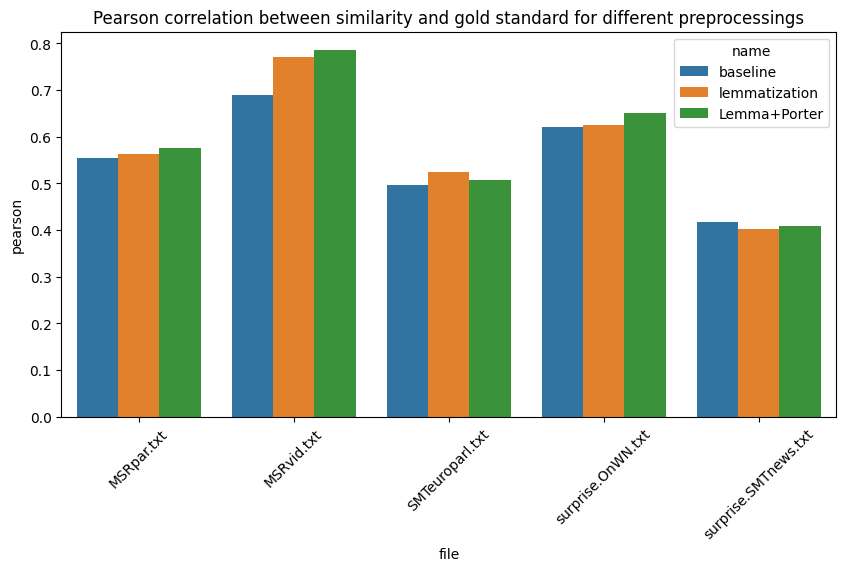

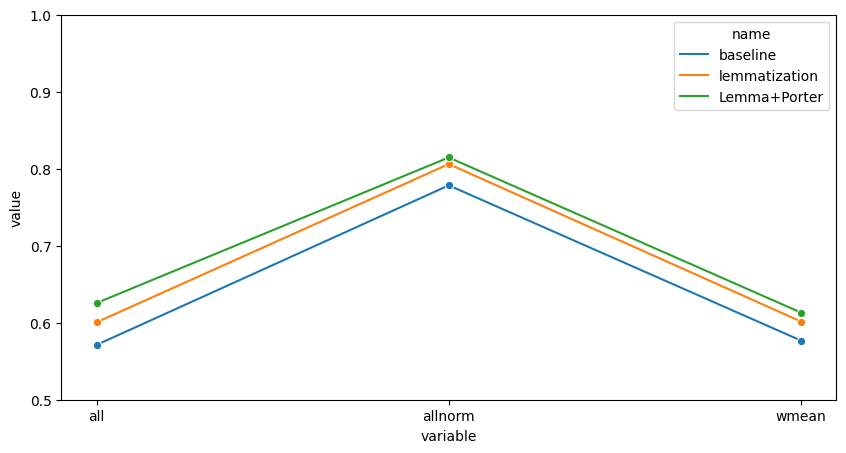

In [64]:
baseline.plot_col_analysis([lemmatized, lemma_porter])
lemma_porter.df_global_scores

## Snowball Stemmer

MSRpar.txt


RAW TEXT (DIFFERENCE -2.93)
It's the first such drill since the September 11 terrorist attacks on New York and Washington. 
 It is the nation's first large-scale counterterrorism exercise since the Sept. 11 terrorist attacks.

PREPROCESSED TEXT
{'11', 'septemb', 'drill', 'york', 'terrorist', 'new', 'washington', 'attack'} 
 {'11', 'nation', 'larg', 'exercis', 'terrorist', 'sept.', 'scale', 'counterterror', 'attack'}
INTERSECTION {'11', 'attack', 'terrorist'}
DIFFERENCE {'septemb', 'nation', 'larg', 'drill', 'exercis', 'york', 'sept.', 'new', 'scale', 'washington', 'counterterror'}



RAW TEXT (DIFFERENCE -2.93)
But butterflies exposed to an earlier light cycle, from 1am to 1pm, orientated themselves towards the south-east. 
 But butterflies housed under an earlier light cycle, 1 a.m. to 1 p.m., flew toward the southeast.

PREPROCESSED TEXT
{'east', 'expos', 'cycl', 'south', 'orient', 'butterfli', '1', 'light', 'earli', 'pm'} 
 {'hous', 'southeast', 'cycl', 'fli', 'butterfl

,file,pearson,p_value,conf_low,conf_high,name
0,MSRpar.txt,0.572573,1.515473e-66,0.522398,0.618798,Lemma+Snowball
1,MSRvid.txt,0.784781,1.443867e-157,0.755646,0.810817,Lemma+Snowball
2,SMTeuroparl.txt,0.507617,1.969299e-31,0.436364,0.572543,Lemma+Snowball
3,surprise.OnWN.txt,0.650546,1.868511e-91,0.607237,0.690000,Lemma+Snowball
4,surprise.SMTnews.txt,0.407641,2.091350e-17,0.322368,0.486352,Lemma+Snowball


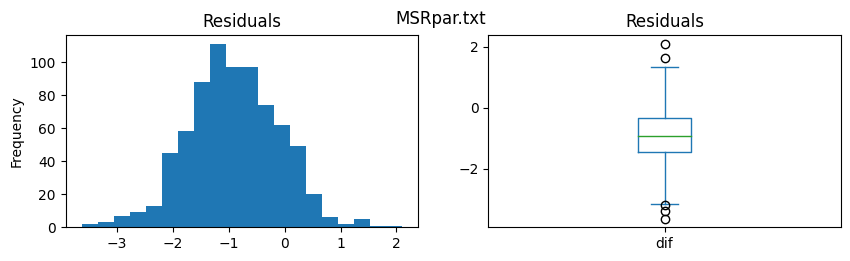

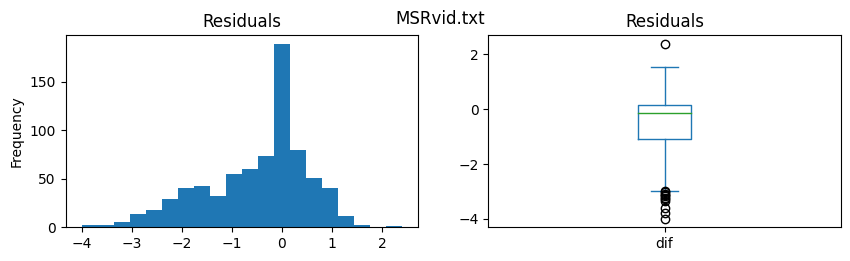

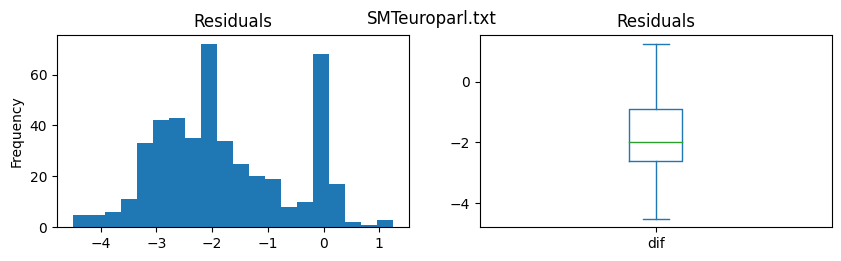

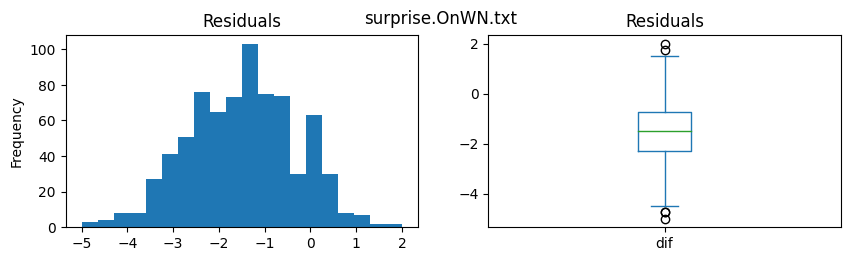

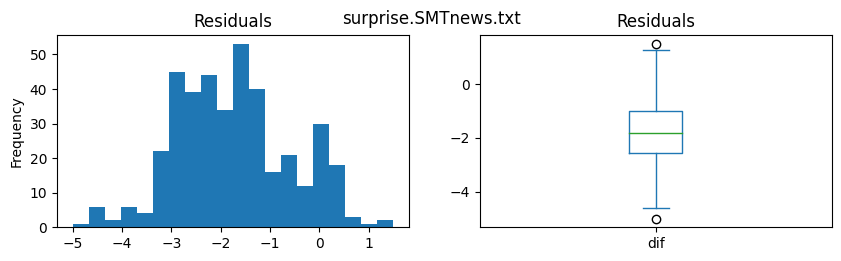

In [65]:
def spacy_preprocess_lemma_snowball(text, sw_lang='english', out_set=False, clean_func=None):
    '''
    Function to preprocess the text - remove punctuations, convert to lowercase, remove stopwords
    Input: text - string
    Output: ls_processed_text - list of words
    '''
    if clean_func is not None:
        text = clean_func(text)

    doc = nlp(text)
    stemmer = SnowballStemmer(sw_lang)
    ls_processed_text = [stemmer.stem(w.lemma_.lower()) for w in doc if not w.is_stop and not w.is_punct]

    if out_set:
        # For distance metrics, usually, it's needed a set of words
        return set(ls_processed_text)
    else:
        return ls_processed_text
    
ls_files = ["MSRpar.txt", "MSRvid.txt", "SMTeuroparl.txt", "surprise.OnWN.txt", "surprise.SMTnews.txt"]
lemma_snow = STSAnalyzer(spacy_preprocess_lemma_snowball, name='Lemma+Snowball')
lemma_snow.col_report(ls_files)
lemma_snow.corr_table(ls_files)

,all,allnorm,wmean,name
0,0.625635,0.813911,0.611831,Lemma+Snowball


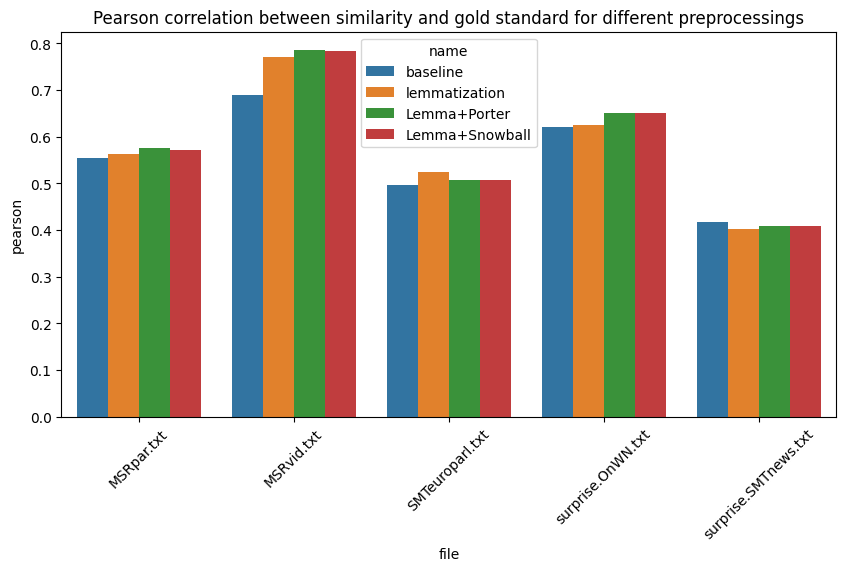

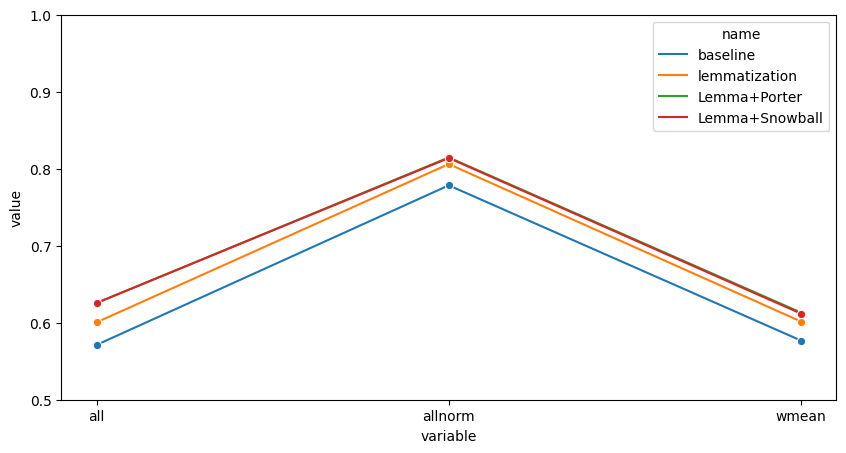

In [66]:
baseline.plot_col_analysis([lemmatized, lemma_porter, lemma_snow])
lemma_snow.df_global_scores

# Conclussions:
- Using lemmatization and stemming improves the correlation with the gold standard. The reason is that, when applying stemming hard rules, it's more likely that the results are the same for variations of the same word if previous lemmatization is applied, given that they are converted into their standard form (infinitive, singular, etc).

- It doesn't work as well for Machine Translation datasets as for the paraphrase ones. This makes sense, given that the problem in this case is that different words are used to explain the same concept so that the translation is not literal. In this case, the lemmatization and stemming techniques are not useful given that it only removes information. More advanced techniques capturing semantic meaning of the words should be used.

## Extra: NLTK and POS tagging. N-Grams Analysis. Text Cleaning.

### NLTK and POS tagging

To give a try to `nltk`, some analysis using the PenTreebank and wordnet corpora have been done. The first one is used to get the POS tag of the words and the second one to get the lemmatized form of the words.

MSRpar.txt


RAW TEXT (DIFFERENCE -2.93)
In exchange, North Korea would be required to end its nuclear weapons program. 
 "In return we expect North Korea to give up nuclear weapons."

PREPROCESSED TEXT
{'end', 'nuclear', 'program', 'require', 'korea', 'weapon', 'north', 'exchange'} 
 {'give', 'expect', 'return', 'nuclear', 'korea', 'weapon', 'north'}
INTERSECTION {'nuclear', 'korea', 'weapon', 'north'}
DIFFERENCE {'give', 'end', 'expect', 'program', 'return', 'require', 'exchange'}



RAW TEXT (DIFFERENCE -2.94)
General Jeffrey said he would donate his military pension to charity for the period he was in office at Yarralumla. 
 Maj-Gen Jeffery said he would give his military pension to charity while he served at Yarralumla.

PREPROCESSED TEXT
{'general', 'jeffrey', 'donate', 'say', 'charity', 'military', 'period', 'pension', 'yarralumla', 'office'} 
 {'give', 'pension', 'serve', 'say', 'maj-gen', 'charity', 'military', 'jeffery', 'yarralumla'}
INTERSECTION {'say', 'charity', 'military

,file,pearson,p_value,conf_low,conf_high,name
0,MSRpar.txt,0.545854,1.847309e-59,0.493552,0.594222,nltk_wn_lemma
1,MSRvid.txt,0.759783,5.384714e-142,0.727780,0.788485,nltk_wn_lemma
2,SMTeuroparl.txt,0.483065,3.272221e-28,0.409651,0.550263,nltk_wn_lemma
3,surprise.OnWN.txt,0.643610,6.085906e-89,0.599650,0.683697,nltk_wn_lemma
4,surprise.SMTnews.txt,0.358501,1.518659e-13,0.269823,0.441150,nltk_wn_lemma


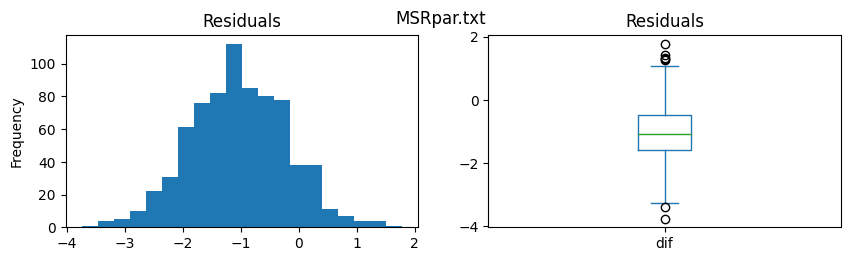

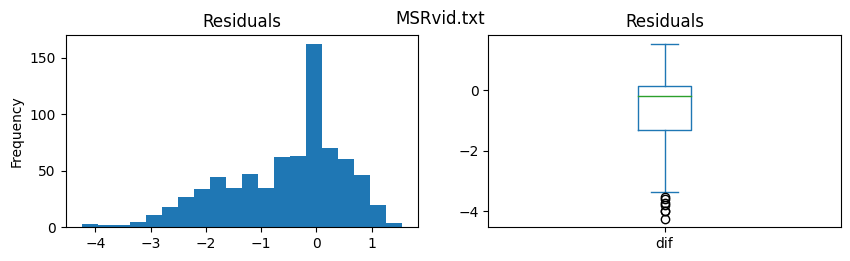

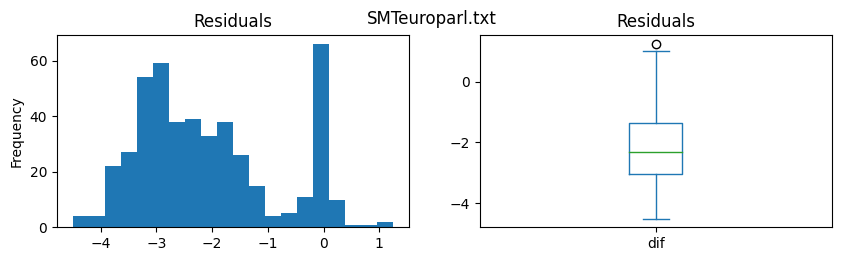

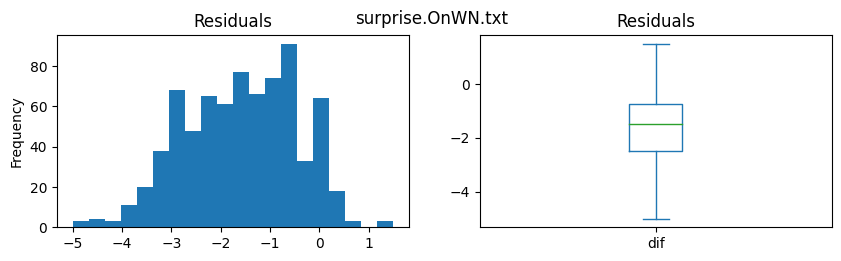

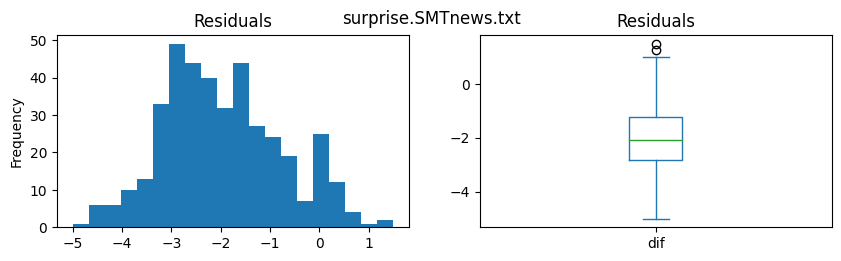

In [69]:
wnl = WordNetLemmatizer()
def lemmatize(p):
  d = {'NN': 'n', 'NNS': 'n', 
       'JJ': 'a', 'JJR': 'a', 'JJS': 'a', 
       'VB': 'v', 'VBD': 'v', 'VBG': 'v', 'VBN': 'v', 'VBP': 'v', 'VBZ': 'v', 'VBP':'v',
       'RB': 'r', 'RBR': 'r', 'RBS': 'r'}
  if p[1] in d:
    return wnl.lemmatize(p[0], pos=d[p[1]])
  return p[0]

def nltk_preprocess_lemma_wn(text, sw_lang='english', out_set=False):
    '''
    Function to preprocess the text - remove punctuations, convert to lowercase, remove stopwords
    Input: text - string
    Output: ls_processed_text - list of words
    '''

    ls_pos = ['NN', 'NNS', 'JJ', 'JJR', 'JJS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'RB', 'RBR', 'RBS',
              'CD', 'FW', 'NNP', 'NNPS', 'WP', 'WP$']
    
    ls_processed_text = [lemmatize(p).lower() for p in nltk.pos_tag(nltk.word_tokenize(text)) if p[1] in ls_pos]
    ls_processed_text = [w for w in ls_processed_text if w not in nltk.corpus.stopwords.words(sw_lang)]
    
    if out_set:
        # For distance metrics, usually, it's needed a set of words
        return set(ls_processed_text)
    else:
        return ls_processed_text
    
sts_nltk_wn = STSAnalyzer(nltk_preprocess_lemma_wn, name='nltk_wn_lemma')
sts_nltk_wn.col_report(ls_files)
sts_nltk_wn.corr_table(ls_files)

In [70]:
sts_nltk_wn.df_global_scores

,all,allnorm,wmean,name
0,0.586327,0.801517,0.587743,nltk_wn_lemma


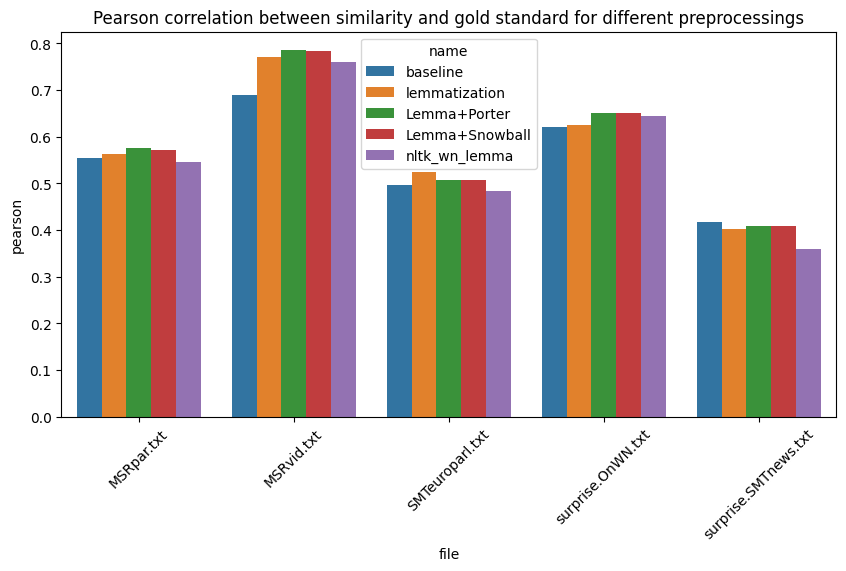

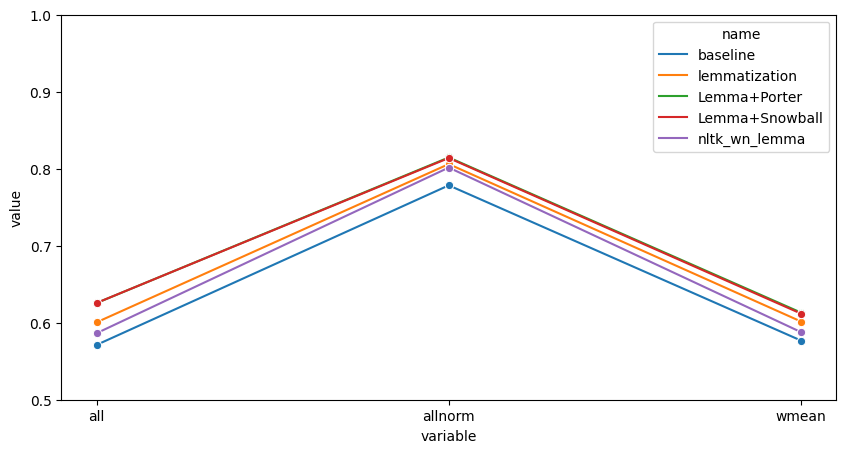

In [71]:
baseline.plot_col_analysis([lemmatized, lemma_porter, lemma_snow, sts_nltk_wn])

**Conclussions:** It didn't work as well as with spacy except for the OnWN dataset. The reason can be that spacy is a bit more aggresive in discarding words that are not useful for the task. This can be useful in cases when the descriptions use a lot of words that are not useful for the task, but in this case, the descriptions are quite short and the words are more likely to be useful. However, in the case of SMTnews, it seems to introduce too much noise, causing the performance to decrease.

This could be solved with a deeper manual filter but spacy works better with less effort.

### N-Grams Analysis

Before doing some cleaning, it's interesting to see the most common n-grams in the dataset. This can give us some insights about the data and the cleaning process.

In [84]:
def get_top_k_ngrams(df, file, col, k=20):
    from nltk import bigrams, trigrams, ngrams
    from nltk.probability import FreqDist
    
    df_ = df[df.file == file].copy()

    ls_unigrams, ls_bigrams, ls_trigrams, ls_tetragrams = [], [], [], []
    for _, row in df_.iterrows():
        # Sample text
        text = nlp(row[col])
        # Tokenize the text into words
        words = [w.lemma_.lower() for w in text if not w.is_punct and not w.is_stop]

        # Create bigrams and trigrams
        bi_grams = list(bigrams(words))
        tri_grams = list(trigrams(words))
        tetra_grams = list(ngrams(words, 4))

        ls_unigrams.extend(words)
        ls_bigrams.extend(bi_grams)
        ls_trigrams.extend(tri_grams)
        ls_tetragrams.extend(tetra_grams)

    # Calculate the frequency of bigrams and trigrams
    unigram_freq = FreqDist(ls_unigrams)
    bi_gram_freq = FreqDist(ls_bigrams)
    tri_gram_freq = FreqDist(ls_trigrams)
    tetra_gram_freq = FreqDist(ls_tetragrams)

    # Find the most common bigrams and trigrams
    most_common_unigrams = [(x, y / sum(unigram_freq.values())) for x, y in unigram_freq.most_common(20)]
    most_common_bi_grams = [(' '.join(x), y / sum(bi_gram_freq.values())) for x, y in bi_gram_freq.most_common(20)]  # Change 5 to the desired number of top bigrams
    most_common_tri_grams = [(' '.join(x), y / sum(tri_gram_freq.values()))  for x, y in tri_gram_freq.most_common(20)]  # Change 5 to the desired number of top trigrams
    most_common_tetra_grams = [(' '.join(x), y / sum(tetra_gram_freq.values())) for x, y in tetra_gram_freq.most_common(20)]

    return most_common_unigrams, most_common_bi_grams, most_common_tri_grams, most_common_tetra_grams

def plot_ngrams(file, k=20):
    uni_euro_0, bi_euro_0, tri_euro_0, tetra_euro_0 = get_top_k_ngrams(baseline.df_col_analysis.drop_duplicates(subset=0), file, 0, k=k)
    uni_euro_1, bi_euro_1, tri_euro_1, tetra_euro_1 = get_top_k_ngrams(baseline.df_col_analysis, file, 1, k=k)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
    plt.suptitle(file)
    ax[0].set_title("Original")
    sns.barplot(y = [x for x,_ in uni_euro_0], x=[y for _,y in uni_euro_0], ax=ax[0], orient='h')
    ax[1].set_title("Paraphrase")
    sns.barplot(y = [x for x,_ in uni_euro_1], x=[y for _,y in uni_euro_1], ax=ax[1], orient='h')
    plt.tight_layout()

    fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
    ax[0].set_title("Original")
    sns.barplot(y = [x for x,_ in bi_euro_0], x=[y for _,y in bi_euro_0], ax=ax[0], orient='h')
    ax[1].set_title("Paraphrase")
    sns.barplot(y = [x for x,_ in bi_euro_1], x=[y for _,y in bi_euro_1], ax=ax[1], orient='h')
    plt.tight_layout()

    fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
    ax[0].set_title("Original")
    sns.barplot(y = [x for x,_ in tri_euro_0], x=[y for _,y in tri_euro_0], ax=ax[0], orient='h')
    ax[1].set_title("Paraphrase")
    sns.barplot(y = [x for x,_ in tri_euro_1], x=[y for _,y in tri_euro_1], ax=ax[1], orient='h')
    plt.tight_layout()

    fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
    ax[0].set_title("Original")
    sns.barplot(y = [x for x,_ in tetra_euro_0], x=[y for _,y in tetra_euro_0], ax=ax[0], orient='h')
    ax[1].set_title("Paraphrase")
    sns.barplot(y = [x for x,_ in tetra_euro_1], x=[y for _,y in tetra_euro_1], ax=ax[1], orient='h')
    plt.tight_layout()

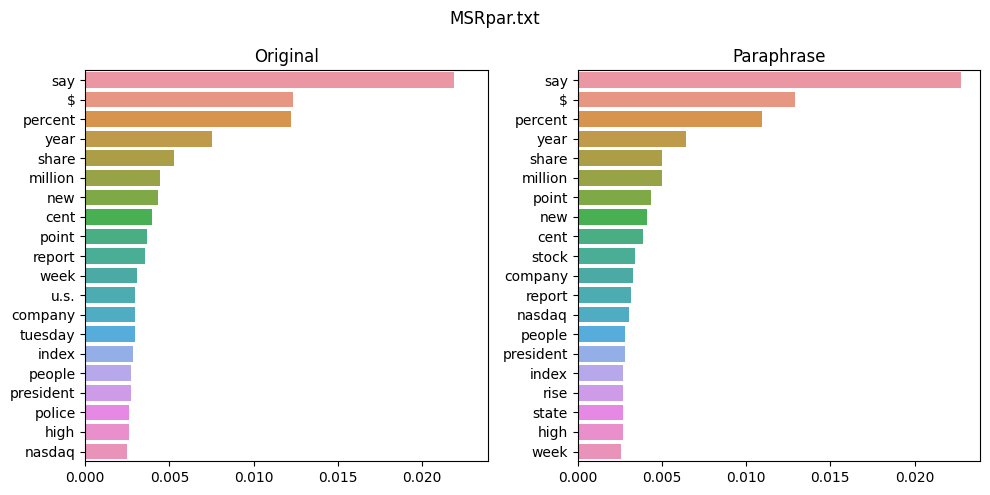

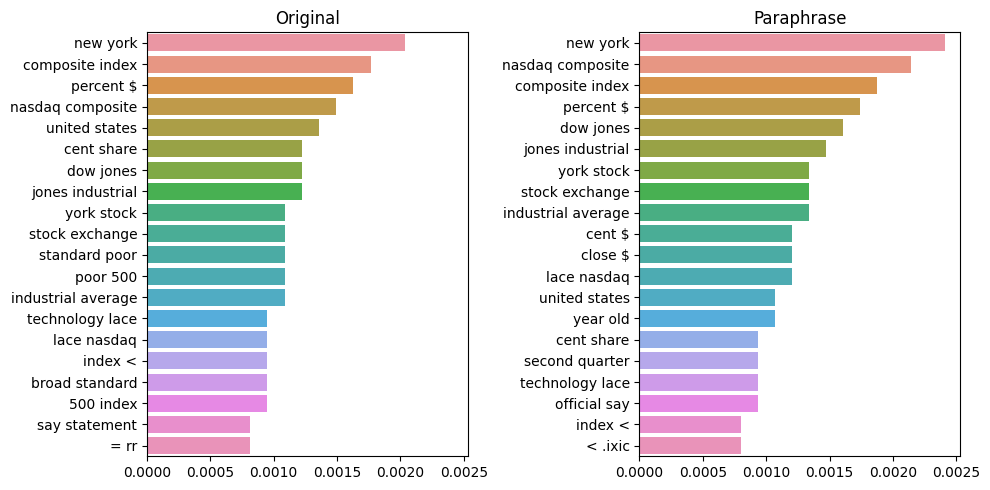

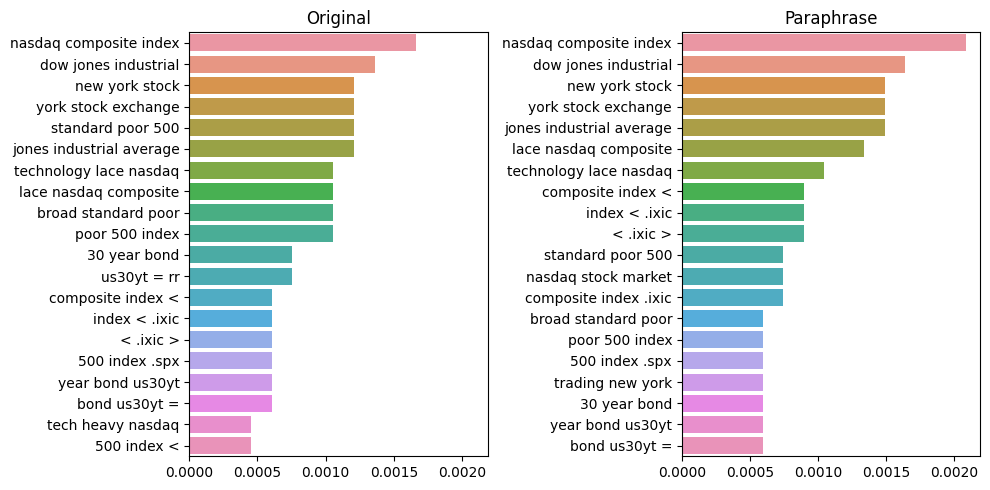

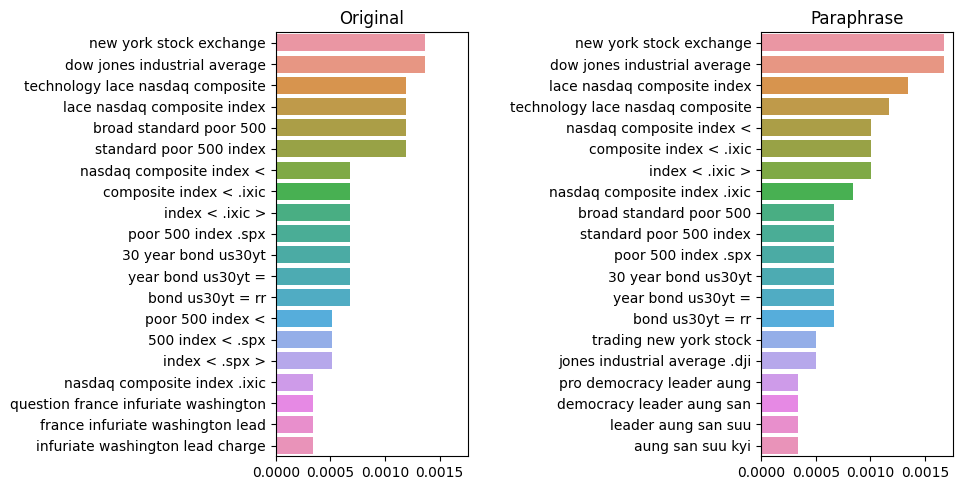

In [85]:
plot_ngrams("MSRpar.txt")

It's observed that there are some words that are not being tokenized correctly. 

Examples:
- The hours are not in a standard mode (20h30 p.m., 1am, 1:30am, etc.)
- Index tags such as < .ixic >, us30yt=rr, etc. This can be fixed and included in the word cleaning function.
- The `$` sign is very often tokenized as a separate word. This can be fixed and included in the word cleaning function.
- percent can be found written as `per cent`
- New York is tokenized as `New` and `York` but they appear very often together. This can be fixed and included in the word cleaning function.

### Clean Data

In [190]:
ls_idx_ex = ["The broader Standard & Poor's 500 Index <.SPX> was up 9.69 points, or 0.98 percent, at 994.53.",
             "The tech-laced Nasdaq Composite Index <.IXIC> gained 18.35 points, or 1.13 percent, to 1,6462.02.",
             "The technology-laced Nasdaq Composite Index <.IXIC> rose 6 points, or 0.41 percent, to 1,498.",
             "Likewise, the 30-year bond <US30YT=RR> slid 1-11/32 for a yield of 4.38 percent, up from 4.30 percent.",
             "The euro <EUR=> was up 0.67 percent against the dollar at $1.1784 after rising to a three-month high earlier in the session above $1.18."]

idx_pattern = re.compile(r'<\W*(\w+)=*(\w*)>', re.IGNORECASE)
ls_idx_ex = [re.sub(idx_pattern, r'\1\2', x) for x in ls_idx_ex]
ls_idx_ex


["The broader Standard & Poor's 500 Index SPX was up 9.69 points, or 0.98 percent, at 994.53.",
 'The tech-laced Nasdaq Composite Index IXIC gained 18.35 points, or 1.13 percent, to 1,6462.02.',
 'The technology-laced Nasdaq Composite Index IXIC rose 6 points, or 0.41 percent, to 1,498.',
 'Likewise, the 30-year bond US30YTRR slid 1-11/32 for a yield of 4.38 percent, up from 4.30 percent.',
 'The euro EUR was up 0.67 percent against the dollar at $1.1784 after rising to a three-month high earlier in the session above $1.18.']

MSRpar.txt


RAW TEXT (DIFFERENCE -3.64)
Sendmail said the system can even be set up to permit business-only usage. 
 The product can be instructed to permit business-only use, according to Sendmail.

PREPROCESSED TEXT
{'said', 'set', 'usage', 'system', 'permit', 'business', 'sendmail'} 
 {'instructed', 'according', 'product', 'permit', 'use', 'business', 'sendmail'}
INTERSECTION {'permit', 'sendmail', 'business'}
DIFFERENCE {'said', 'set', 'according', 'usage', 'instructed', 'product', 'system', 'use'}



MSRvid.txt


RAW TEXT (DIFFERENCE -4.75)
The lady peeled the potatoe. 
 A woman is peeling a potato.

PREPROCESSED TEXT
{'lady', 'potatoe', 'peeled'} 
 {'woman', 'peeling', 'potato'}
INTERSECTION set()
DIFFERENCE {'lady', 'potatoe', 'peeled', 'woman', 'peeling', 'potato'}



SMTeuroparl.txt


RAW TEXT (DIFFERENCE -4.80)
There must be a balance as a whole. 
 All must be balanced.

PREPROCESSED TEXT
{'balance'} 
 {'balanced'}
INTERSECTION set()
DIFFERENCE {'balanced', 'balance'}



sur

,file,pearson,p_value,conf_low,conf_high,name
0,MSRpar.txt,0.593339,1.609086e-72,0.544896,0.637835,Lemma+Snowball+Clean
1,MSRvid.txt,0.784781,1.443867e-157,0.755646,0.810817,Lemma+Snowball+Clean
2,SMTeuroparl.txt,0.525436,6.132524e-34,0.455831,0.588654,Lemma+Snowball+Clean
3,surprise.OnWN.txt,0.650546,1.868511e-91,0.607237,0.690000,Lemma+Snowball+Clean
4,surprise.SMTnews.txt,0.407641,2.091350e-17,0.322368,0.486352,Lemma+Snowball+Clean


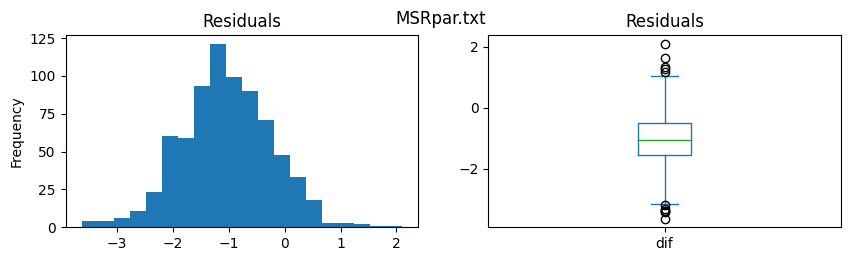

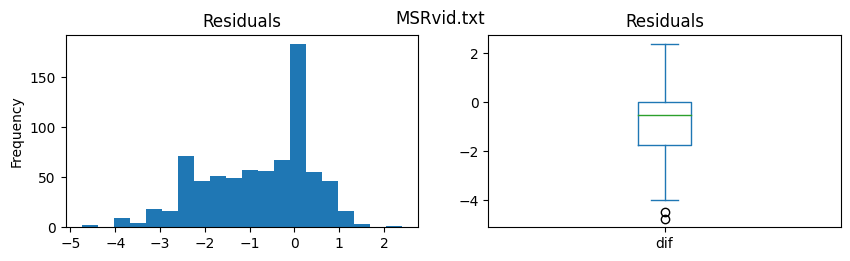

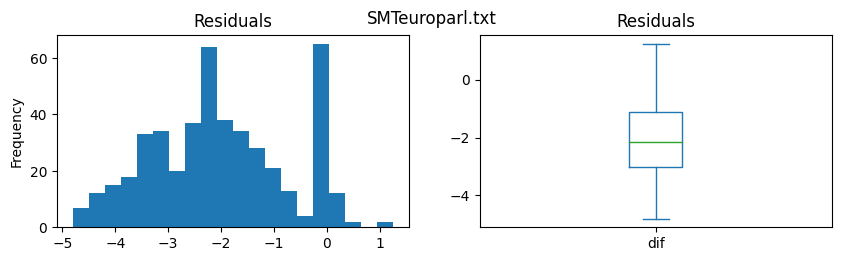

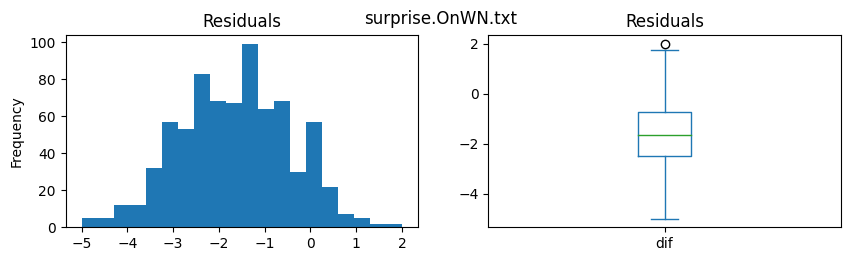

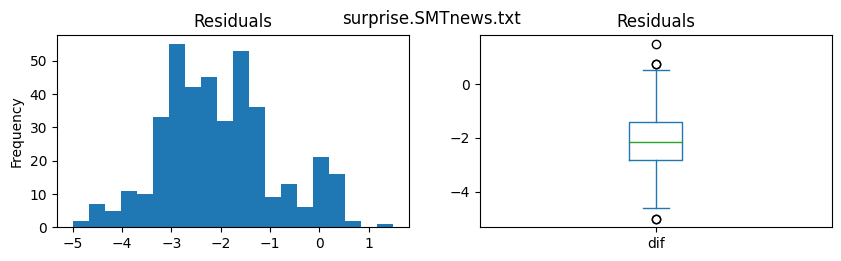

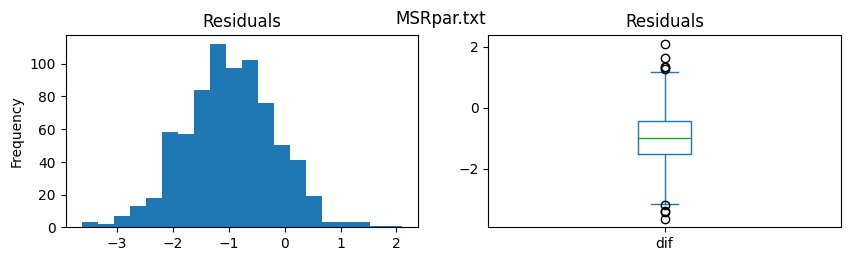

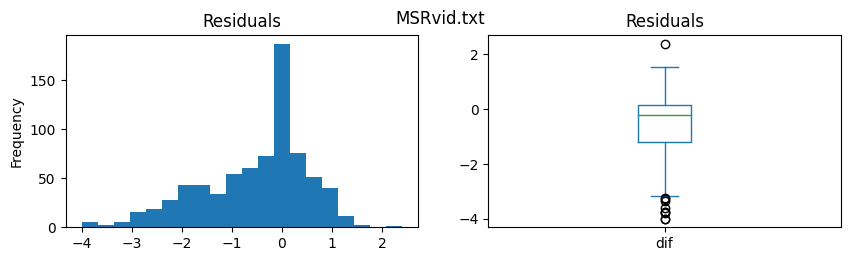

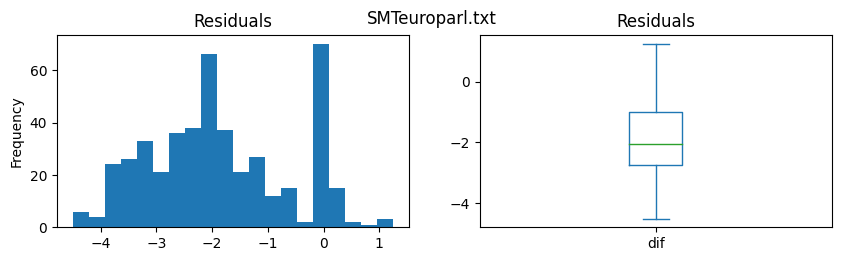

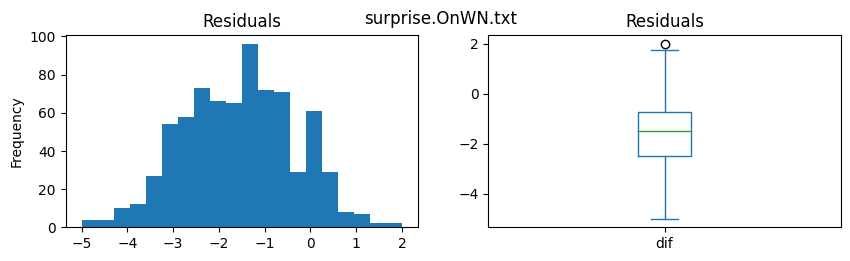

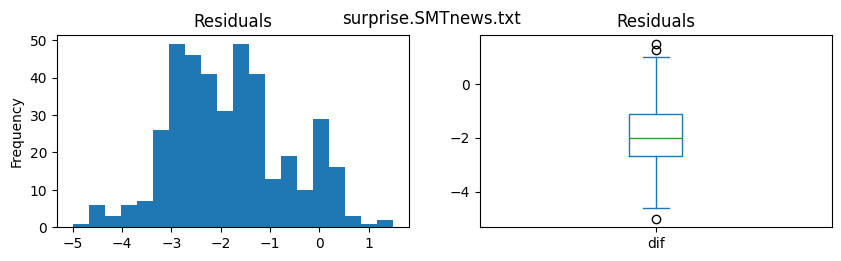

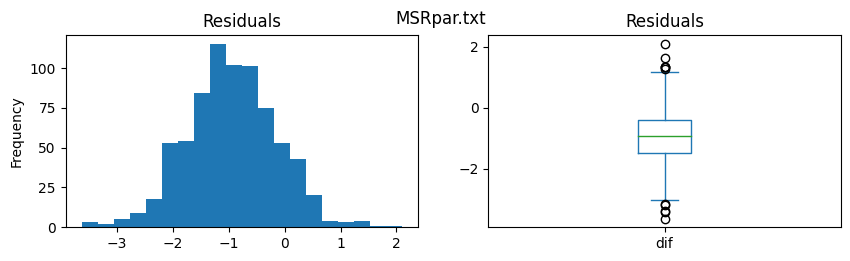

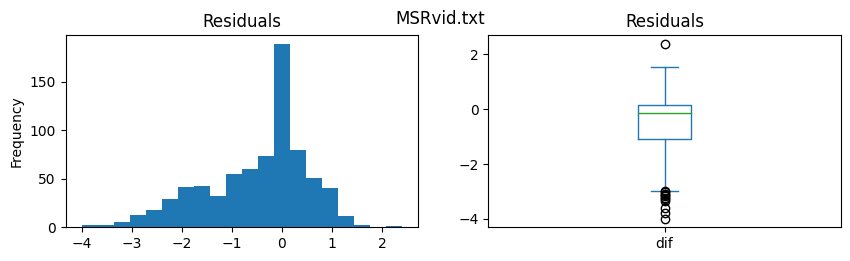

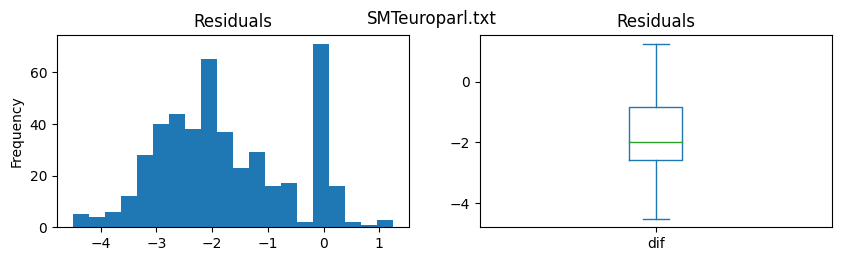

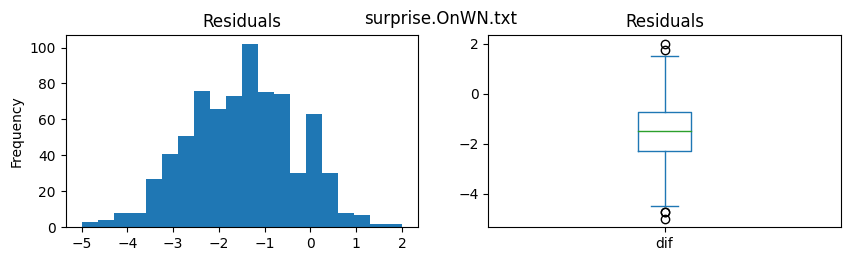

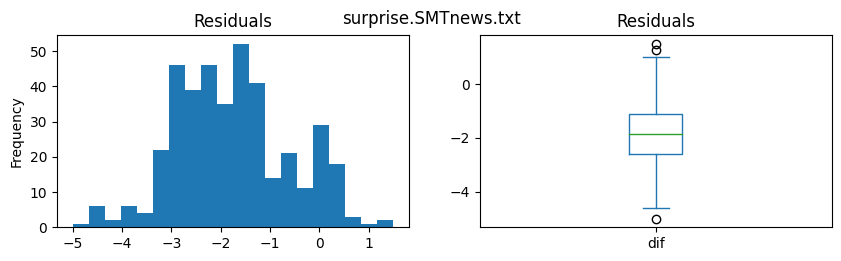

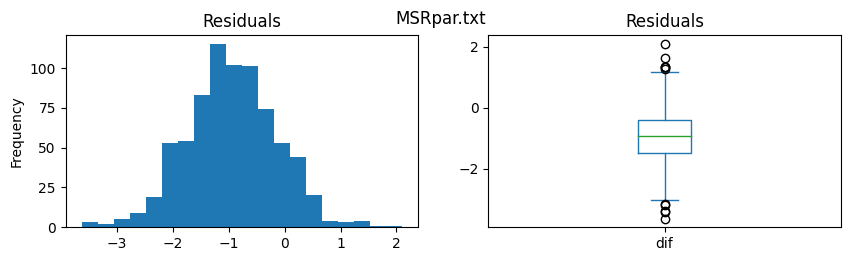

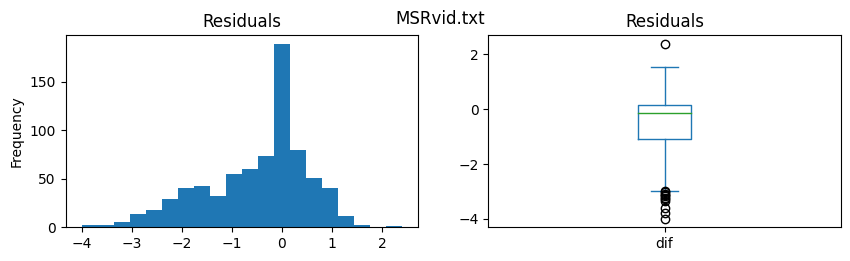

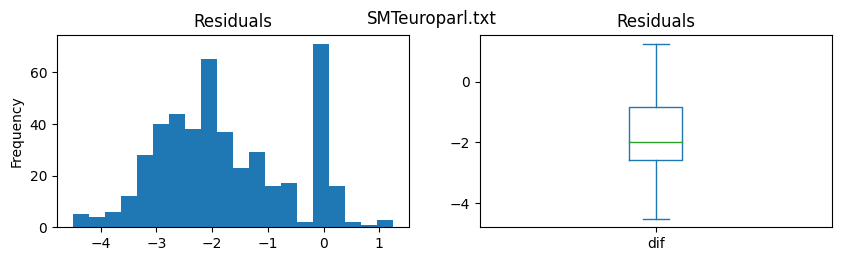

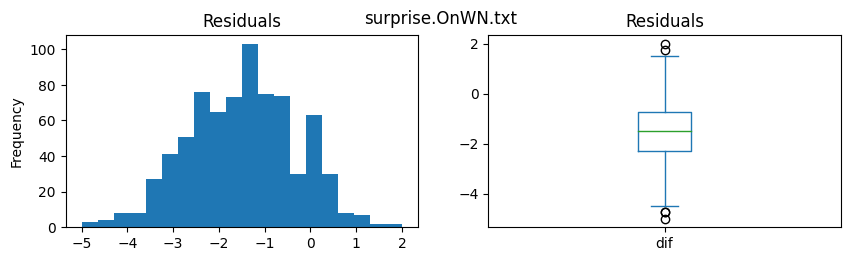

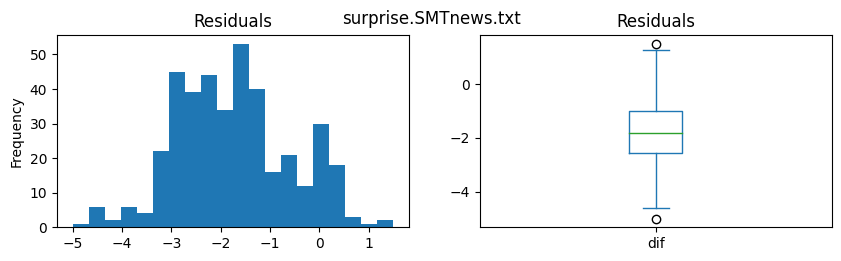

In [93]:
def clean_text(text):

    # Standardize the hours (1pm -> 13:00)
    def convert_to_24_hour(match):
        '''
        Function to convert time to 24 hour format
        Input: match - match object
        Output: string with the time in 24 hour format
        '''
        time_str = match.groups()
        hour, minute, am_pm = time_str[0], '' if time_str[1] is None else time_str[1] ,  re.sub('\.', '', '' if time_str[2] is None else time_str[2])
        # print(time_str)
        if am_pm == 'pm':
            if minute == '':
                return str(int(hour) + 12) + ':00'
            else:
                return str(int(hour) + 12) + ':' + minute
        elif am_pm == 'am':
            if hour == '12':
                return "00" + ':' + minute
            elif minute == '':
                return hour + ':00'
            else:
                return hour + ':' + minute
        else:
            if minute == '':
                return hour + ':00'
            else:
                return hour + ':' + minute

    hour_pattern_1 = re.compile(r'(?<=\s)(\d+)\s?()([ap]\.?m\.?)')
    hour_pattern_2 = re.compile(r'(\d+)[:\.](\d+)\s?([ap]\.?m\.?)')
    hour_pattern_3 = re.compile(r'(\d+)\s?[h:]\s?(\d+)\s?([ap]\.?m\.?)?')
    ls_patterns = [hour_pattern_1, hour_pattern_2, hour_pattern_3]
    for pat in ls_patterns:
        text = re.sub(pat, convert_to_24_hour, text)

    # Delete rests of abbreviated particles
    particle_pattern = re.compile(r"\b(?:'s|'d|'ll|'m|'re|'ve)\b", re.IGNORECASE)
    formatted_text = re.sub(particle_pattern, '', text)

    # Delete rests of abbreviated words to refer people
    mr_ms_pattern = re.compile(r"\b(mr.|mr|ms|ms.|mss.)\b", re.IGNORECASE)
    formatted_text = re.sub(mr_ms_pattern, '', formatted_text)

    # Convert indexes to a single word
    idx_pattern = re.compile(r'<\W*(\w+)=*(\w*)>', re.IGNORECASE)
    formatted_text = re.sub(idx_pattern, r'\1\2', formatted_text)
    
    # Remove the point from words starting with it
    start_point_pattern = re.compile(r'(\W)\.(\w+)', re.IGNORECASE)
    formatted_text = re.sub(start_point_pattern, r'\2', formatted_text)

    # Remove the comma from thousands (standardize)
    thousands_pattern = re.compile(r'(\d+),(\d+)', re.IGNORECASE)
    formatted_text = re.sub(thousands_pattern, r'\1\2', formatted_text)

    # Transform percentages to a single word
    percent_pattern = re.compile(r'(\d+)\s*per\s*cent', re.IGNORECASE)
    formatted_text = re.sub(percent_pattern, r'\1_%', formatted_text)
    
    # Remove the dollar sign from money
    money_pattern = re.compile(r'\$', re.IGNORECASE)
    formatted_text = re.sub(money_pattern, '' , formatted_text)

    return formatted_text

def spacy_preprocess_reviews(text, sw_lang='english', out_set=False, clean_func=None):
    '''
    Function to preprocess the text - remove punctuations, convert to lowercase, remove stopwords
    Input: text - string
    Output: ls_processed_text - list of words
    '''
    if clean_func is not None:
        text = clean_func(text)

    doc = nlp(text)
    ls_processed_text = [w.text.lower() for w in doc if not w.is_stop and not w.is_punct]
    if out_set:
        # For distance metrics, usually, it's needed a set of words
        return set(ls_processed_text)
    else:
        return ls_processed_text

def spacy_preprocess_reviews_clean(x, **kwargs): return spacy_preprocess_reviews(x, clean_func=clean_text, **kwargs)
def spacy_preprocess_lemma_clean(x, **kwargs): return spacy_preprocess_lemma(x, clean_func=clean_text, **kwargs)
def spacy_preprocess_lemma_porter_clean(x, **kwargs): return spacy_preprocess_lemma_porter(x, clean_func=clean_text, **kwargs)
def spacy_preprocess_lemma_snowball_clean(x, **kwargs): return spacy_preprocess_lemma_snowball(x, clean_func=clean_text, **kwargs)

ls_files = ["MSRpar.txt", "MSRvid.txt", "SMTeuroparl.txt", "surprise.OnWN.txt", "surprise.SMTnews.txt"]
baseline_clean = STSAnalyzer(spacy_preprocess_reviews_clean, name='Baseline+clean')
baseline_clean.col_report(ls_files, n_show=1)
baseline_clean.corr_table(ls_files)

lemmatized_clean = STSAnalyzer(spacy_preprocess_lemma_clean, name='Lemma+Clean')
lemmatized_clean.col_report(ls_files, n_show=1)
lemmatized_clean.corr_table(ls_files)

lemma_porter_clean = STSAnalyzer(spacy_preprocess_lemma_porter_clean, name='Lemma+Porter+Clean')
lemma_porter_clean.col_report(ls_files, n_show=1)
lemma_porter_clean.corr_table(ls_files)
#
lemma_snow_clean = STSAnalyzer(spacy_preprocess_lemma_snowball_clean, name='Lemma+Snowball+Clean')
lemma_snow_clean.col_report(ls_files, n_show=1)
lemma_snow_clean.corr_table(ls_files)

In [95]:
baseline.df_global_scores

,all,allnorm,wmean,name
0,0.571166,0.7784,0.576817,baseline


In [96]:
pd.concat([baseline_clean.df_global_scores,
              lemmatized_clean.df_global_scores,
              lemma_porter_clean.df_global_scores,
              lemma_snow_clean.df_global_scores], axis=0, ignore_index=True)

,all,allnorm,wmean,name
0,0.577664,0.780336,0.584294,Baseline+clean
1,0.606672,0.807938,0.609138,Lemma+Clean
2,0.631572,0.816485,0.620748,Lemma+Porter+Clean
3,0.631642,0.815768,0.619474,Lemma+Snowball+Clean


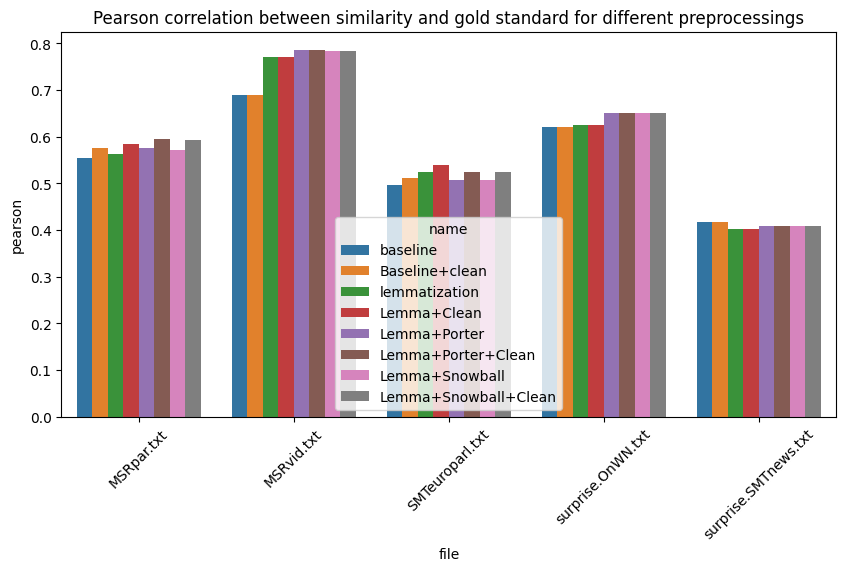

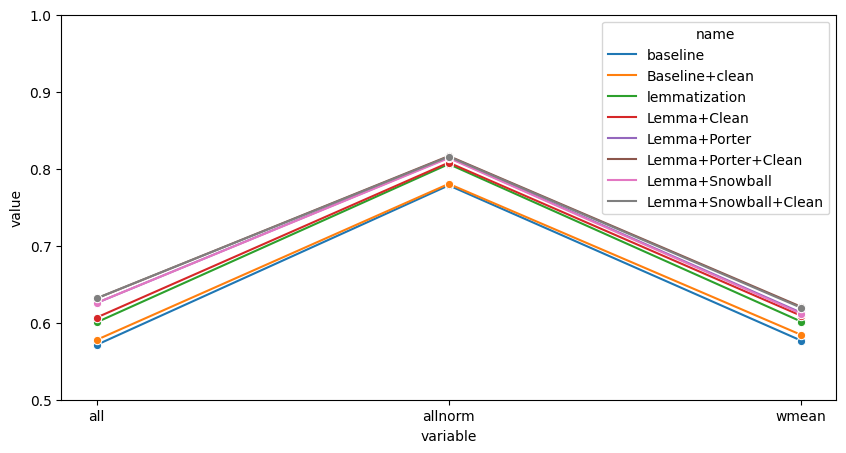

In [97]:
baseline.plot_col_analysis([baseline_clean, lemmatized, lemmatized_clean, lemma_porter, lemma_porter_clean, lemma_snow, lemma_snow_clean])

# Results and Conclussions

The best results are obtained from the combination of Lemmatizing and Stemming. The cleaning process became in a significant improvement. The most important changes are in `MSRpar` because our cleaning process was mainly focused on it. The other dataset which improved significantly was `SMTeuroparl` due to the presence of a lot of non-standardized hours.

In following versions of this deliverables further improvements will be done. For example, the cleaning process can be improved by adding more rules to the word cleaning function.